In [1]:
import itertools
import logging
import warnings

import duckdb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_gbq 

from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly, plot_cross_validation_metric
from prophet.diagnostics import cross_validation, performance_metrics
#from pandas.tseries.offsets import DateOffset

DATABASE_NAME = "etl"
PROJECT_ID = "new-life-400922"
TABLE_NAME = "res_tickers_history"

warnings.filterwarnings("ignore")
logger = logging.getLogger()
#logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.ERROR)


/Users/evan/.pyenv/versions/3.11.5/envs/de/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def query_ticker_data(ticker):
    sql = f"""
        SELECT *
        FROM `new-life-400922.etl.res_tickers_history`
        WHERE ticker = '{ticker}'
    """
    # Run a Standard SQL query with the project set explicitly
    df = pd.read_gbq(sql, project_id=PROJECT_ID, dialect="standard")
    return df

In [3]:
apple = query_ticker_data('AAPL').set_index('date')
netflix = query_ticker_data('NFLX').set_index('date')
meta = pd.read_gbq("SELECT * FROM `new-life-400922.etl.res_tickers_by_month` WHERE ticker = 'META' AND date >'2022-06-09'", project_id=PROJECT_ID, dialect="standard").set_index('date')
fb = query_ticker_data('FB').set_index('date')
microsoft = query_ticker_data('MSFT').set_index('date')
amazon = query_ticker_data('AMZN').set_index('date')
alphabet = query_ticker_data('GOOGL').set_index('date')
coke = query_ticker_data('KO').set_index('date')

apple.name = "Apple"
netflix.name = "Netflix"
fb.name = "Facebook"
meta.name = "Meta"
microsoft.name = "Microsoft"
amazon.name = "Amazon"
alphabet.name = "Alphabet"
coke.name = "Coca-Cola Co"

In [4]:
TARGET_DF = apple

In [5]:
vwap = TARGET_DF['volume_weighted_average_price']

In [6]:
TARGET_DF['simple_rtn'] = vwap.pct_change()
TARGET_DF['log_rtn'] = np.log(vwap/vwap.shift(1))

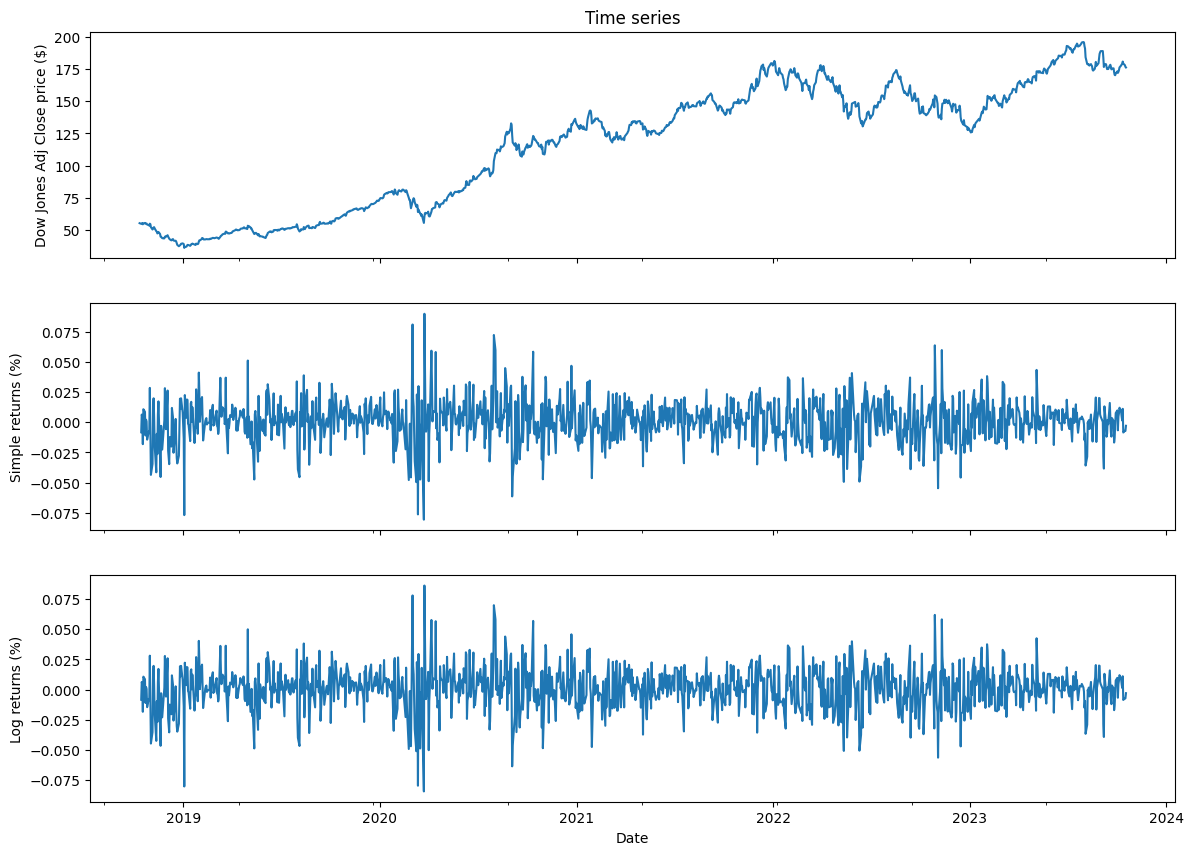

In [7]:
fig, ax = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
vwap.plot(ax=ax[0])
ax[0].set(title = 'Time series', ylabel = 'Dow Jones Adj Close price ($)')
TARGET_DF.simple_rtn.plot(ax=ax[1])
ax[1].set(ylabel = 'Simple returns (%)')
TARGET_DF.log_rtn.plot(ax=ax[2])
ax[2].set(xlabel = 'Date', ylabel = 'Log returns (%)')
plt.show()

In [8]:
hist = TARGET_DF[['volume_weighted_average_price']]
hist.reset_index(level=0, inplace=True)
hist = hist.rename({'date': 'ds', 'volume_weighted_average_price': 'y'}, axis='columns')

In [9]:
param_grid = { 
    "daily_seasonality": [False],
    "weekly_seasonality": [False],
    "yearly_seasonality": [False, True],
    "growth": ["linear"],
    "seasonality_mode": ["additive", "multiplicative"],    
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params)
    #m= m.add_seasonality(name="quarterly", period=63, fourier_order=10)
    #m.add_country_holidays("US")
    m = m.fit(hist)  # Fit model with given params
    df_cv = cross_validation(m, initial='1095 days', period='63 days', horizon = '252 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
tuning_results

23:10:20 - cmdstanpy - INFO - Chain [1] start processing
23:10:20 - cmdstanpy - INFO - Chain [1] done processing
23:10:21 - cmdstanpy - INFO - Chain [1] start processing
23:10:21 - cmdstanpy - INFO - Chain [1] done processing
23:10:22 - cmdstanpy - INFO - Chain [1] start processing
23:10:22 - cmdstanpy - INFO - Chain [1] start processing
23:10:22 - cmdstanpy - INFO - Chain [1] done processing
23:10:22 - cmdstanpy - INFO - Chain [1] done processing
23:10:22 - cmdstanpy - INFO - Chain [1] start processing
23:10:22 - cmdstanpy - INFO - Chain [1] start processing
23:10:22 - cmdstanpy - INFO - Chain [1] start processing
23:10:22 - cmdstanpy - INFO - Chain [1] start processing
23:10:22 - cmdstanpy - INFO - Chain [1] done processing
23:10:22 - cmdstanpy - INFO - Chain [1] start processing
23:10:22 - cmdstanpy - INFO - Chain [1] done processing
23:10:22 - cmdstanpy - INFO - Chain [1] done processing
23:10:22 - cmdstanpy - INFO - Chain [1] done processing
23:10:22 - cmdstanpy - INFO - Chain [1]

,daily_seasonality,weekly_seasonality,yearly_seasonality,growth,seasonality_mode,changepoint_prior_scale,seasonality_prior_scale,rmse
0,False,False,False,linear,additive,0.001,0.01,34.078492
1,False,False,False,linear,additive,0.001,0.10,34.078492
2,False,False,False,linear,additive,0.001,1.00,34.078492
3,False,False,False,linear,additive,0.001,10.00,34.078492
4,False,False,False,linear,additive,0.010,0.01,31.470736
...,...,...,...,...,...,...,...,...
59,False,False,True,linear,multiplicative,0.100,10.00,33.885503
60,False,False,True,linear,multiplicative,0.500,0.01,36.158399
61,False,False,True,linear,multiplicative,0.500,0.10,44.335823
62,False,False,True,linear,multiplicative,0.500,1.00,44.488476


In [17]:
# Python
best_params = all_params[np.argmin(rmses)]
best_params

{'daily_seasonality': False,
 'weekly_seasonality': False,
 'yearly_seasonality': False,
 'growth': 'linear',
 'seasonality_mode': 'additive',
 'changepoint_prior_scale': 0.01,
 'seasonality_prior_scale': 0.01}

23:14:51 - cmdstanpy - INFO - Chain [1] start processing
23:14:52 - cmdstanpy - INFO - Chain [1] done processing


Predicted Data
             ds        yhat  yhat_lower  yhat_upper
1518 2024-10-11  196.648533  181.093317  213.757768
1519 2024-10-14  196.815222  181.042058  213.585138
1520 2024-10-15  196.870785  179.967786  213.740766
1521 2024-10-16  196.926348  182.279451  212.965656
1522 2024-10-17  196.981910  182.209619  212.374730


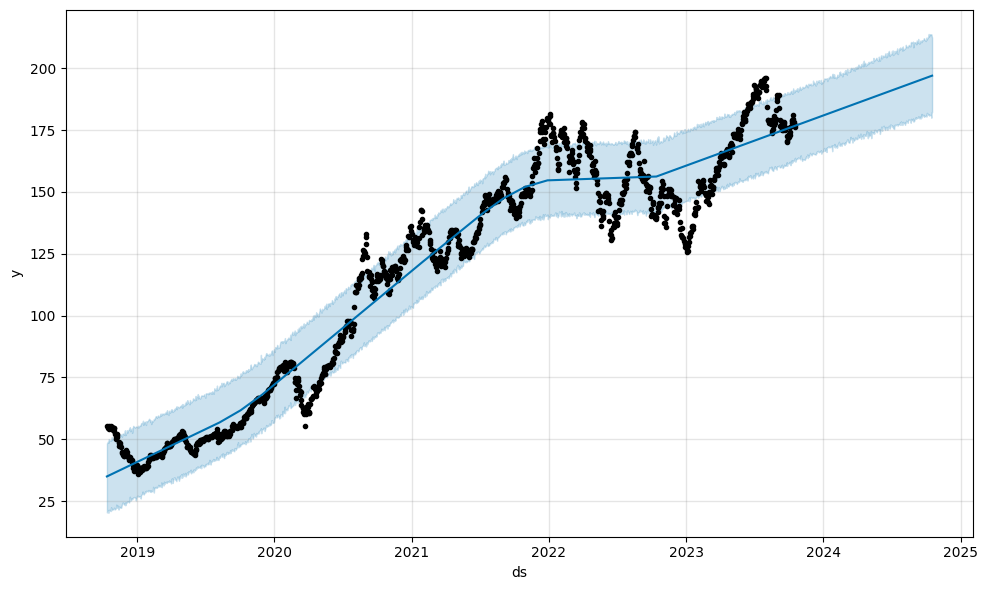

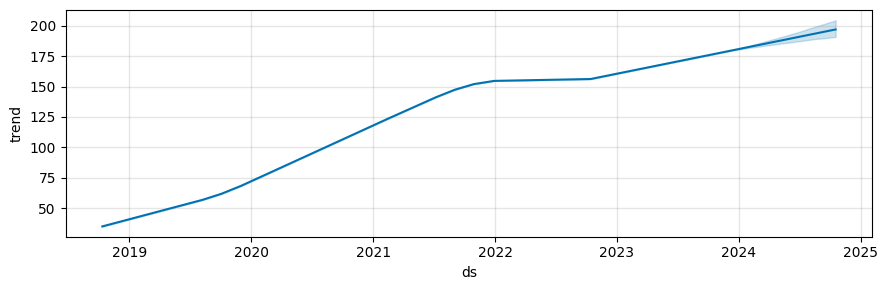

In [18]:
"""
param ={
    "daily_seasonality": False,
    "weekly_seasonality": False,
    "yearly_seasonality": True,
    "growth": "linear",
    "seasonality_mode": "additive",
    'changepoint_prior_scale': 0.01, 
    'seasonality_prior_scale': 10.0
}
"""

m = Prophet(**best_params)
#m= m.add_seasonality(name="monthly", period=30, fourier_order=10)
#m= m.add_seasonality(name="quarterly", period=63, fourier_order=10)
#m.add_country_holidays("US")
m.fit(hist)
future = m.make_future_dataframe(periods=365, freq='D')
future = future[future['ds'].dt.dayofweek < 5]
forecast = m.predict(future)
print("Predicted Data")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5))
figure1 = m.plot(forecast)
figure2 = m.plot_components(forecast)

fig1 = plot_plotly(m, forecast, figsize=(1000,600)) # 
fig2 = plot_components_plotly(m, forecast, figsize=(1000,600))

In [19]:
df_cv = cross_validation(m, initial='1095 days', period='90 days', horizon = '365 days', parallel="processes")

23:15:09 - cmdstanpy - INFO - Chain [1] start processing
23:15:09 - cmdstanpy - INFO - Chain [1] start processing
23:15:09 - cmdstanpy - INFO - Chain [1] start processing
23:15:09 - cmdstanpy - INFO - Chain [1] start processing
23:15:09 - cmdstanpy - INFO - Chain [1] start processing
23:15:09 - cmdstanpy - INFO - Chain [1] done processing
23:15:09 - cmdstanpy - INFO - Chain [1] done processing
23:15:09 - cmdstanpy - INFO - Chain [1] done processing
23:15:09 - cmdstanpy - INFO - Chain [1] done processing
23:15:09 - cmdstanpy - INFO - Chain [1] done processing


In [20]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,36 days,195.344541,13.976571,9.713542,0.064468,0.038660,0.060639,0.738667
1,37 days,193.950850,13.926624,9.613093,0.063790,0.036466,0.060002,0.744000
2,38 days,193.818095,13.921857,9.621647,0.063767,0.036513,0.060012,0.736000
3,39 days,194.724281,13.954364,9.679880,0.064055,0.038660,0.060336,0.728000
4,40 days,200.110826,14.146053,9.798846,0.064869,0.036513,0.061054,0.728000
...,...,...,...,...,...,...,...,...
325,361 days,2140.042799,46.260597,40.859060,0.274213,0.269960,0.236693,0.120000
326,362 days,2154.862417,46.420496,40.982226,0.275197,0.289542,0.237202,0.120000
327,363 days,2149.195951,46.359421,40.926924,0.274643,0.272746,0.236980,0.114000
328,364 days,2155.111298,46.423176,41.009693,0.274903,0.281198,0.237286,0.107200


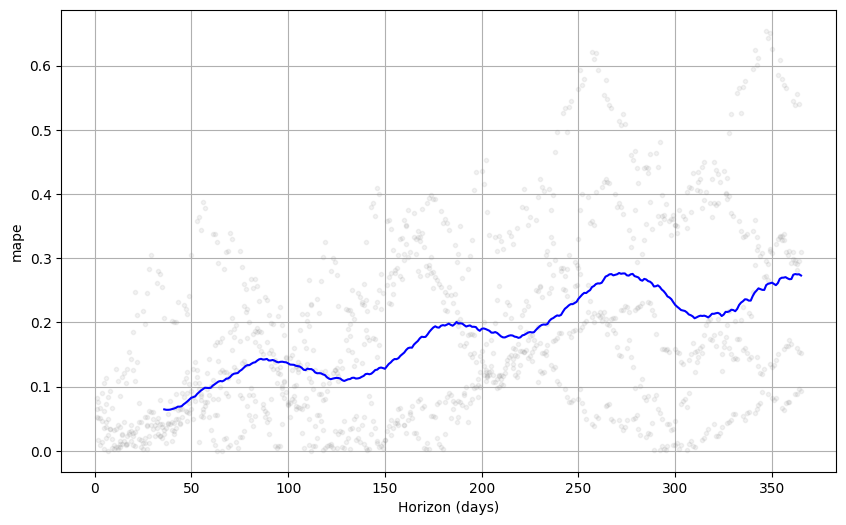

In [21]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [22]:
duckdb.sql("select cutoff, count(*) from df_cv group by 1 order by 1").df()

,cutoff,count_star()
0,2021-10-23,251
1,2022-01-21,250
2,2022-04-21,251
3,2022-07-20,251
4,2022-10-18,251


In [24]:
df_cv[df_cv.cutoff=="2022-07-20	"]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
752,2022-07-21,162.588743,150.473843,174.848583,154.3545,2022-07-20
753,2022-07-22,162.626311,150.013712,175.324705,154.6233,2022-07-20
754,2022-07-25,162.739017,150.296350,174.897679,153.3004,2022-07-20
755,2022-07-26,162.776586,150.671999,175.885090,151.6799,2022-07-20
756,2022-07-27,162.814155,149.694071,175.757054,155.2412,2022-07-20
...,...,...,...,...,...,...
998,2023-07-14,176.038346,161.801209,188.943463,190.4662,2022-07-20
999,2023-07-17,176.151053,160.259465,189.451225,193.2997,2022-07-20
1000,2023-07-18,176.188621,161.244251,190.611289,193.3846,2022-07-20
1001,2023-07-19,176.226190,162.433186,190.825060,194.9188,2022-07-20
